# Google Merchandise Store - customer analytics dashboard

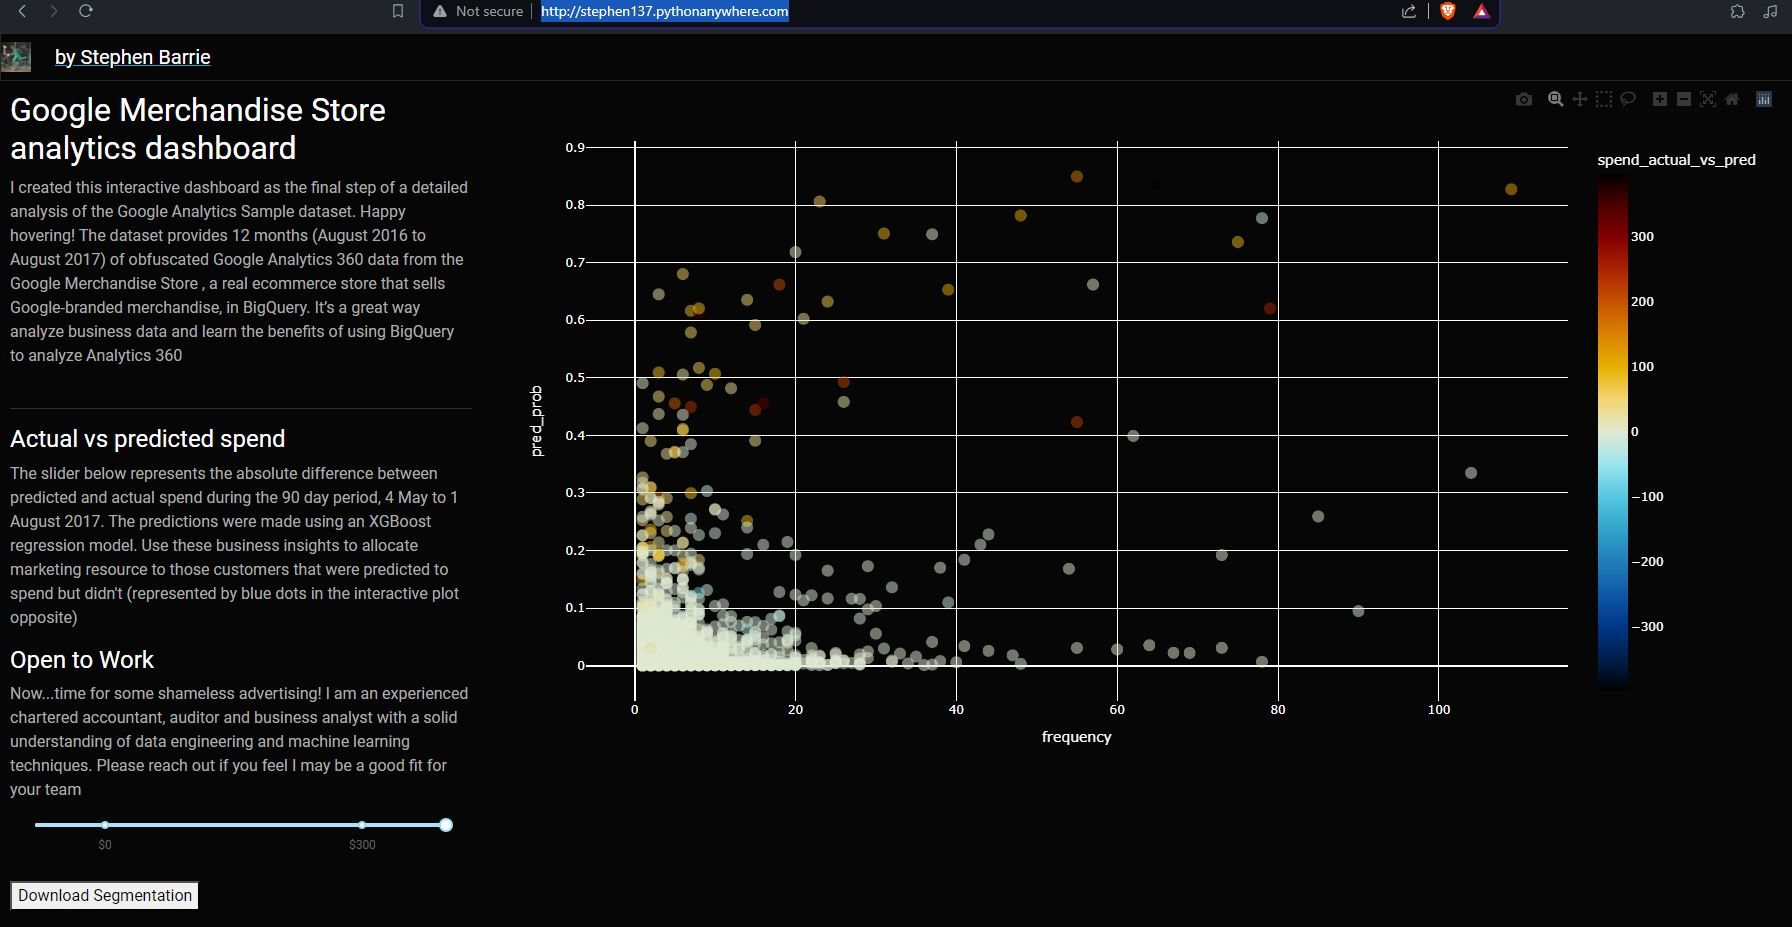

## 1. Project Overview

My starting point for this project is to frame two common business problems faced by the [Google Merchandise Store](https://shop.googlemerchandisestore.com/) and ecommerce businesses in general.

### Frame the business problem

- What will customers spend in the next 90-days? (Regression)
- What is the probability that a customer will make a purchase in the next 90-days? (Classification)

In order to provide insights to these questions, we first need to :

### Translate the raw data into meaningful visualizations and insights

- explore athe dataset to extract meaningful trends, patterns and anomalies regarding customer behaviour
- visualize using plotly and plotnine
- create additional RMF (Recency, Monetary, Frequency) to unlock hidden insights 

### Use the insights to make future predictions

- train a machine learnign regression mode to predict the `$` customer spend in the next-90 days
- train a machine learning classification model to predict the `likelihood` of customer spend in the next-90 days


### Communicate using an interactive dashboard

- present the findings of my analysis through an interactive dashboard
- share my findings through deployment of a Dash [ecommerce customer analytics app](http://stephen137.pythonanywhere.com/)


### Move from insights to actionable outcomes

We can use these predictions to identify :

- Which customers have the highest spend `probability` in next 90-days?

> **target for new products similar to what they have purchased in the past**


- Which customers have recently purchased (within 90 days) but are `unlikely` to buy (probability less than 30%)? 

> **incentivize actions to increase probability**\
> **provide discounts, encourage referring a friend, nurture by letting them know what's coming**


- Missed opportunities: Big spenders that could be unlocked?

> **Send bundle offers encouraging volume purchases**\
> **Focus on missed opportunities**

By adopting this approach ecommerce businesses can make informed decisions to improve customer satisfaction, increase sales, and enhance overall operational efficiency.

## 2. Customer Lifetime Value

Companies use this metric to gauge profitability and to identify which customers to focus on. In short, CLV is the estimated profit from the future relationship with a customer. There are many different approaches to modeling CLV.

### 2.1 `Economic / cashflow approach`  

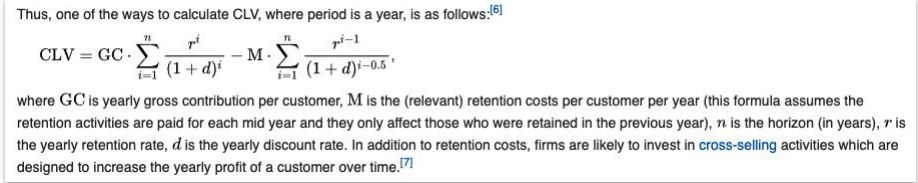

Challenges with this approach:

- Lifetime value is great, but more important is a pre-defined period of time, for example the next 90-days

### 2.2 `Machine learning approach` 

- Step 1: Subset a cohort
- Step 2: Temoral splitting - use future information to develop targets
- Step 3: Create RFM features (Recency, Frequency, Monetary)

### 3. Dataset, schema, packages

The dataset I will be analysing is the [Google Analytics sample dataset for BigQuery](https://support.google.com/analytics/answer/7586738?hl=en&ref_topic=3416089&sjid=15552203920864108300-EU#zippy=%2Cin-this-article). 

The sample dataset contains obfuscated Google Analytics 360 data from the [Google Merchandise Store](https://www.googlemerchandisestore.com/shop.axd/Home?utm_source=Partners&utm_medium=affiliate&utm_campaign=Data%20Share%20Promo), a real ecommerce store. The Google Merchandise Store sells Google branded merchandise. The data is typical of what you would see for an ecommerce website. It includes the following kinds of information:

- `Traffic source data:` information about where website visitors originate. This includes data about organic traffic, paid search traffic, display traffic, etc.
- `Content data:` information about the behavior of users on the site. This includes the URLs of pages that visitors look at, how they interact with content, etc.
- `Transactional data:` information about the transactions that occur on the Google Merchandise Store website.

The dataset covers the 366 day period 1 August 2016 to 1 August 2017. 

#### 3.1 Schema

Before diving into our analysis, it is good practice to explore the dataset schema. 

If you take a close look at [the schema](https://support.google.com/analytics/answer/3437719?hl=en) you will see that the structure involves nested fields. It can be extremely cost-effective (both in terms of storage and in terms of query time) to use nested fields rather than flatten out all your data. Nested, repeated fields are very powerful, but the SQL required to query them looks a bit unfamiliar. So, it’s worth spending a little time with `STRUCT`, `UNNEST` and `ARRAY_AGG.` 


Fields which are of type INTEGER or STRING can be accessed directly. However things a bit trickier as we go deeper into the structure. 

`totals` for example is of Type `RECORD` and includes sub-variables. In order to access these we need to use `dot` notation:

    totals.visits
    
Things get even trickier with fields of Type `RECORD` and Mode `Repeated`, for example `hits`. In order to access the subvariable `hitNumber` we need to use the `UNNEST()` function, give it an alias, and then we can use `dot` notation :

    SELECT
        h.hitNumber
    FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS h
    
We can go even deeper. To access `hits.product.productRevenue` we need to first UNNEST hits and then because product is also of Type `RECORD` and Mode `Repeated` we have to UNNEST(hits.product). Expanding on the above example :

    SELECT
        h.hitNumber,
        p.productRevenue
    FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS h,
    UNNEST(hits.product) AS p

Google cloud have [learnng resources](https://cloud.google.com/bigquery/docs/arrays) to help you.

OK, now that I've gotten to know the dataset a bit better it's time to dive into some exploratory analysis.

### 3.2 A Kind of Magic

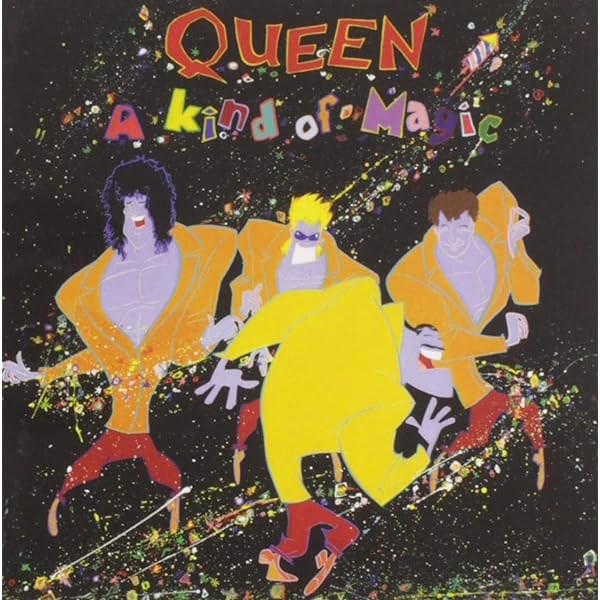

Jupyter notebooks (which i am using for this project) provide a convenient interactive computing environment for various programming languages, including Python.  You might be aware of so called `magic` commands, denoted by a % or %% symbol. These are special commands that enhance the functionality and provide additional features within Jupyter notebooks. Here's a brief summary of some commonly used magic commands:

#### Line Magic Commands (%):

- `%run:` Execute a Python script as if it were a program.
- `%load:` Load code into a cell from an external script.
- `%pwd:` Print the current working directory.
- `%cd:` Change the current working directory.
- `%ls:` List the contents of the current directory.
- `%matplotlib:` Enable interactive Matplotlib plots.

#### Cell Magic Commands (%%):

- `%%time:` Measure the time it takes for the code in the cell to run.
- `%%html:` Render the cell content as HTML.


#### Interactive Shell Commands:

- `!:` Run shell commands directly from a Jupyter cell.

### 3.3 Import packages and libraries

%load_ext google.cloud.bigquery 
from google.cloud import bigquery
import google.cloud.bigquery
from google.oauth2 import service_account

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import pytimetk as tk
import plotly.express as px
import joblib 
from missingno import matrix # missing data

#!pip install plydata
import plydata.cat_tools as cat
import plotnine as pn
import pytimetk as tk
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

pn.options.dpi = 300

## 4. Exploratory Data Analysis

### 4.1 Using %%bigquery to run SQL within Jupyter

The **%%bigquery** magic which allows you to run SQL queries on data held in BigQuery from the comfort of your own local Jupyter Notebook. 

The data is separated into daily tables but you can use `_*` to access everything, and if you specify a name after %%big query, it will return a pandas DataFrame!

In [2]:
%%bigquery total_days
SELECT COUNT(DISTINCT date) AS number_days
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
total_days

,number_days
0,366


In [4]:
type(total_days)

pandas.core.frame.DataFrame

In [5]:
%%bigquery
SELECT COUNT(*)
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`

Query is running:   0%|          |

Downloading:   0%|          |

,f0_
0,903653


Ok, so the dataset covers a period of 366 days and contains 903,653 rows. Let's preview one day :

In [6]:
%%bigquery sample_day
SELECT *
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170713`

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
sample_day

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,<NA>,2,1500008750,1500008750,20170713,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",137294517588272857,None,None,Direct,Not Socially Engaged
1,<NA>,1,1499957243,1499957243,20170713,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 7, 'minut...",4373106646092857768,None,None,Direct,Not Socially Engaged
2,<NA>,1,1499968083,1499968083,20170713,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 10, 'minu...",160773093174680026,None,None,Direct,Not Socially Engaged
3,<NA>,2,1499952856,1499952856,20170713,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 6, 'minut...",1117853031731048699,None,None,Direct,Not Socially Engaged
4,<NA>,4,1499982847,1499982847,20170713,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 14, 'minu...",1319757127869798182,None,None,Display,Not Socially Engaged
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,<NA>,1,1499986111,1499986111,20170713,"{'visits': 1, 'hits': 73, 'pageviews': 57, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 15, 'minu...",4100305414080508541,None,None,Organic Search,Not Socially Engaged
2737,<NA>,5,1499969354,1499969354,20170713,"{'visits': 1, 'hits': 86, 'pageviews': 57, 'ti...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...",806992249032686650,None,None,Referral,Not Socially Engaged
2738,<NA>,1,1499931174,1499931174,20170713,"{'visits': 1, 'hits': 132, 'pageviews': 85, 't...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",3917496719101325275,None,None,Direct,Not Socially Engaged
2739,<NA>,1,1499951313,1499951315,20170713,"{'visits': 1, 'hits': 156, 'pageviews': 109, '...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 2, 'time': 0, 'hour': 6, 'minut...",9417857471295131045,None,None,Direct,Not Socially Engaged


As previously discussed, a lot of nested fields to unravel. 

In [8]:
sample_day.glimpse()

<class 'pandas.core.frame.DataFrame'>: 2741 rows of 16 columns
visitorId:             Int64             [<NA>, <NA>, <NA>, <NA>, <NA>,  ...
visitNumber:           Int64             [2, 1, 1, 2, 4, 1, 3, 2, 1, 1,  ...
visitId:               Int64             [1500008750, 1499957243, 149996 ...
visitStartTime:        Int64             [1500008750, 1499957243, 149996 ...
date:                  object            ['20170713', '20170713', '20170 ...
totals:                object            [{'visits': 1, 'hits': 1, 'page ...
trafficSource:         object            [{'referralPath': None, 'campai ...
device:                object            [{'browser': 'Firefox', 'browse ...
geoNetwork:            object            [{'continent': 'Americas', 'sub ...
customDimensions:      object            [array([{'index': 4, 'value': ' ...
hits:                  object            [array([{'hitNumber': 1, 'time' ...
fullVisitorId:         object            ['137294517588272857', '4373106 ...
userId:      

### 4.2 Generate our master data for further analysis

In [13]:
%%bigquery google_merch_store

SELECT 
    fullVisitorId,
    date,    
    product.productQuantity AS quantity,
    product.v2ProductName AS product_name,
    product.productPrice / 1000000 AS price, 
    product.productQuantity * product.productPrice / 1000000 AS product_revenue,
    totals.totalTransactionRevenue / 1000000 AS total_transaction_revenue
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, 
    UNNEST (hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type = '6' # Completed purchase    
    AND product.productQuantity > 0
    AND product.productPrice > 0 
    AND totals.totalTransactionRevenue > 0 # This value is 1 for sessions with interaction events.
ORDER BY
    date

Query is running:   0%|          |

Downloading:   0%|          |

In [15]:
google_merch_store

,fullVisitorId,date,quantity,product_name,price,product_revenue,total_transaction_revenue
0,3213840074316400693,20160801,20,Color Changing Grip Pen,1.20,24.00,170.40
1,3213840074316400693,20160801,20,Kick Ball,1.59,31.80,170.40
2,3213840074316400693,20160801,20,Electronics Accessory Pouch,3.99,79.80,170.40
3,3213840074316400693,20160801,20,Badge Holder,1.59,31.80,170.40
4,2976178532750719771,20160801,4,Maze Pen,0.99,3.96,19.93
...,...,...,...,...,...,...,...
36741,8016003971239765913,20170801,2,Android Men's Short Sleeve Hero Tee White,6.80,13.60,131.96
36742,8016003971239765913,20170801,1,Women's Performance Full Zip Jacket Black,67.19,67.19,131.96
36743,8016003971239765913,20170801,1,Android Men's Engineer Short Sleeve Tee Charcoal,15.99,15.99,131.96
36744,8016003971239765913,20170801,1,Google Infant Short Sleeve Tee Red,13.59,13.59,131.96


### 4.3 PyTimeTK

While the Python ecosystem offers tools like pandas, they sometimes can be verbose and not optimized for all operations, especially for complex time-based aggregations and visualizations. [pytimetk](https://github.com/business-science/pytimetk) significantly simplifies the process of time series manipulation and visualization. By leveraging the polars backend, you can experience speed improvements ranging from 3X to 3500X.

A usefuly feature is `.glimpse()` which does what it says on the tin :

In [16]:
google_merch_store.glimpse()

<class 'pandas.core.frame.DataFrame'>: 36746 rows of 7 columns
fullVisitorId:              object            ['3213840074316400693', '3 ...
date:                       object            ['20160801', '20160801', ' ...
quantity:                   Int64             [20, 20, 20, 20, 4, 1, 1,  ...
product_name:               object            ['Color Changing Grip Pen' ...
price:                      float64           [1.2, 1.59, 3.99, 1.59, 0. ...
product_revenue:            float64           [24.0, 31.8, 79.8, 31.8, 3 ...
total_transaction_revenue:  float64           [170.4, 170.4, 170.4, 170. ...


### 4.4 Custom profile function

This custom function aids the EDA process and is a pseeudo hybrid of pandas `.info()` and `.describe()` :

In [17]:
# Custom profiling function
def profile_data(data):
    """Panda Profiling Function

    Args:
        data (DataFrame): A data frame to profile

    Returns:
        DataFrame: A data frame with profiled data
    """
    return pd.concat(
        [
            pd.Series(data.dtypes, name = "Dtype"),
            # Counts
            pd.Series(data.count(), name = "Count"),
            pd.Series(data.isnull().sum(), name = "NA Count"),
            pd.Series(data.nunique(), name = "Count Unique"),
            # Stats
            pd.Series(data.min(), name = "Min"),
            pd.Series(data.max(), name = "Max"),
            pd.Series(data.mean(), name = "Mean"),
            pd.Series(data.median(), name = "Median"),
            pd.Series(data.mode().iloc[0], name = "Mode"),
        ],
        axis=1
    )

In [18]:
profile_data(google_merch_store)

,Dtype,Count,NA Count,Count Unique,Min,Max,Mean,Median,Mode
fullVisitorId,object,36746,0,9995,0000213131142648941,9998996003043230595,inf,4.512553e+18,1957458976293878100
date,object,36746,0,365,20160801,20170801,inf,2.017013e+07,20161212
quantity,Int64,36746,0,123,1,1000,6.423584,1.000000e+00,1
product_name,object,36746,0,490,1 oz Hand Sanitizer,YouTube Youth Short Sleeve Tee Red,NaN,NaN,Google Sunglasses
price,float64,36746,0,264,0.79,250.0,16.602405,1.329000e+01,13.59
product_revenue,float64,36746,0,2001,0.79,9495.0,45.727660,1.749000e+01,13.59
total_transaction_revenue,float64,36746,0,6199,1.2,47082.06,366.675515,1.022000e+02,23.99


So we can very quickly see that our dataset consists of `36,746` purchase transactions made by `9,995` unique customers and the common purchase was Google sunglasses. 

Before we progress, we need to convert date from an object type to datetime: 

In [20]:
# Convert the date column to datetime64 with nanosecond precision
google_merch_store['date'] = pd.to_datetime(google_merch_store['date'], format='%Y%m%d')

google_merch_store.glimpse()

<class 'pandas.core.frame.DataFrame'>: 36746 rows of 7 columns
fullVisitorId:              object            ['3213840074316400693', '3 ...
date:                       datetime64[ns]    [Timestamp('2016-08-01 00: ...
quantity:                   Int64             [20, 20, 20, 20, 4, 1, 1,  ...
product_name:               object            ['Color Changing Grip Pen' ...
price:                      float64           [1.2, 1.59, 3.99, 1.59, 0. ...
product_revenue:            float64           [24.0, 31.8, 79.8, 31.8, 3 ...
total_transaction_revenue:  float64           [170.4, 170.4, 170.4, 170. ...


## 5. Feature pre-processing

### 5.1.1 Subset a Cohort

In [21]:
# Show only the first transaction made by each unique customer
cust_first_purch = google_merch_store \
    .sort_values(['fullVisitorId', 'date']) \
    .groupby('fullVisitorId') \
    .first()

cust_first_purch

,date,quantity,product_name,price,product_revenue,total_transaction_revenue
fullVisitorId,,,,,,
0000213131142648941,2017-04-28,1,BLM Sweatshirt,33.59,33.59,39.59
0002871498069867123,2016-08-23,15,Google Metallic Notebook Set,5.99,89.85,97.35
0003450834640354121,2016-10-18,1,Google Laptop and Cell Phone Stickers,1.99,1.99,59.95
0003961110741104601,2017-05-21,1,YouTube Custom Decals,1.99,1.99,10.98
000435324061339869,2016-10-20,1,Google Men's Zip Hoodie,44.79,44.79,46.79
...,...,...,...,...,...,...
9991633376050115277,2017-02-17,1,BLM Sweatshirt,33.59,33.59,35.59
9994767073213036303,2016-08-09,3,Electronics Accessory Pouch,4.99,14.97,140.32
9997409246962677759,2016-12-08,1,Crunch Noise Dog Toy,3.99,3.99,40.36


In [22]:
cust_first_purch['date'].min()

Timestamp('2016-08-01 00:00:00')

In [23]:
cust_first_purch['date'].max()

Timestamp('2017-08-01 00:00:00')

### 5.1.2 Visualize all purchases within cohort

In [24]:
# grab date values for our y axis, and price for our x axis
google_merch_store \
    .reset_index() \
    .set_index('date')[['price']]

,price
date,
2016-08-01,1.20
2016-08-01,1.59
2016-08-01,3.99
2016-08-01,1.59
2016-08-01,0.99
...,...
2017-08-01,6.80
2017-08-01,67.19
2017-08-01,15.99


In [25]:
# Aggregate all customer revenue per month
google_merch_store\
    .reset_index() \
    .set_index('date')[['price']] \
    .resample(
        rule = "MS" # group by month
    ) \
    .sum()

,price
date,
2016-08-01,68604.07
2016-09-01,44910.37
2016-10-01,45032.57
2016-11-01,48906.36
2016-12-01,81358.52
2017-01-01,36202.85
2017-02-01,37402.96
2017-03-01,52514.72
2017-04-01,48165.02


<AxesSubplot: xlabel='date'>

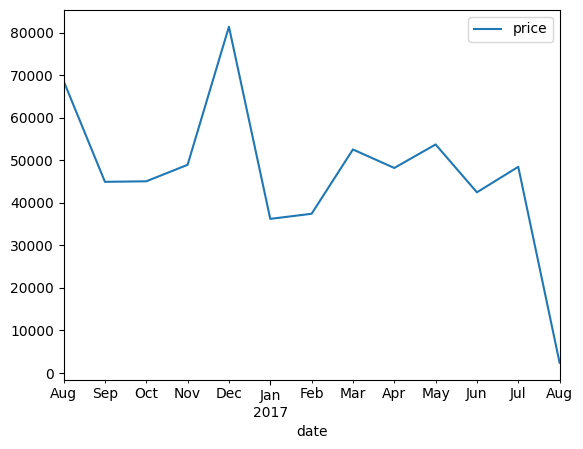

In [26]:
# plot the time series
google_merch_store \
    .reset_index() \
    .set_index('date')[['price']] \
    .resample(
        rule = "MS" # group by month
    ) \
    .sum() \
    .plot()

### 5.1.3 Visualize individual customer purchases

In [27]:
ids = google_merch_store['fullVisitorId'].unique()
ids

array(['3213840074316400693', '2976178532750719771',
       '6569605994631186947', ..., '3101662058536674321',
       '9308310352918219134', '8016003971239765913'], dtype=object)

In [28]:
# select a radom slice of 10 customers
ids_selected = ids[989:999]

google_merch_store \
    [google_merch_store['fullVisitorId'].isin(ids_selected)] \
    .groupby(['fullVisitorId', 'date']) \
    .sum() \
    .reset_index()

,fullVisitorId,date,quantity,price,product_revenue,total_transaction_revenue
0,1293664043695932921,2016-08-30,3,23.17,23.17,29.10
1,330289116549575054,2016-08-31,1,27.19,27.19,47.95
2,330289116549575054,2017-01-12,2,73.58,73.58,165.16
3,4019564737576499248,2016-08-30,38,98.33,335.62,2878.05
4,4332670999936880007,2016-08-31,1,98.99,98.99,123.65
5,435373542373805498,2016-08-30,8,127.92,127.92,1160.80
6,435373542373805498,2016-11-05,1,44.79,44.79,45.79
7,435373542373805498,2016-12-01,5,227.15,227.15,1170.75
8,5423659711610895780,2016-08-30,16,260.30,285.48,3385.14
9,5542047417982345824,2016-08-30,16,63.51,71.49,921.90


In [29]:
cust_id_subset_df = google_merch_store \
    [google_merch_store['fullVisitorId'].isin(ids_selected)] \
    .groupby(['fullVisitorId', 'date']) \
    .sum() \
    .reset_index()

### 5.1.4 Visualize first 10 customers' purchasing 

/home/stephen137/mambaforge/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/stephen137/mambaforge/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/stephen137/mambaforge/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/stephen137/mambaforge/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


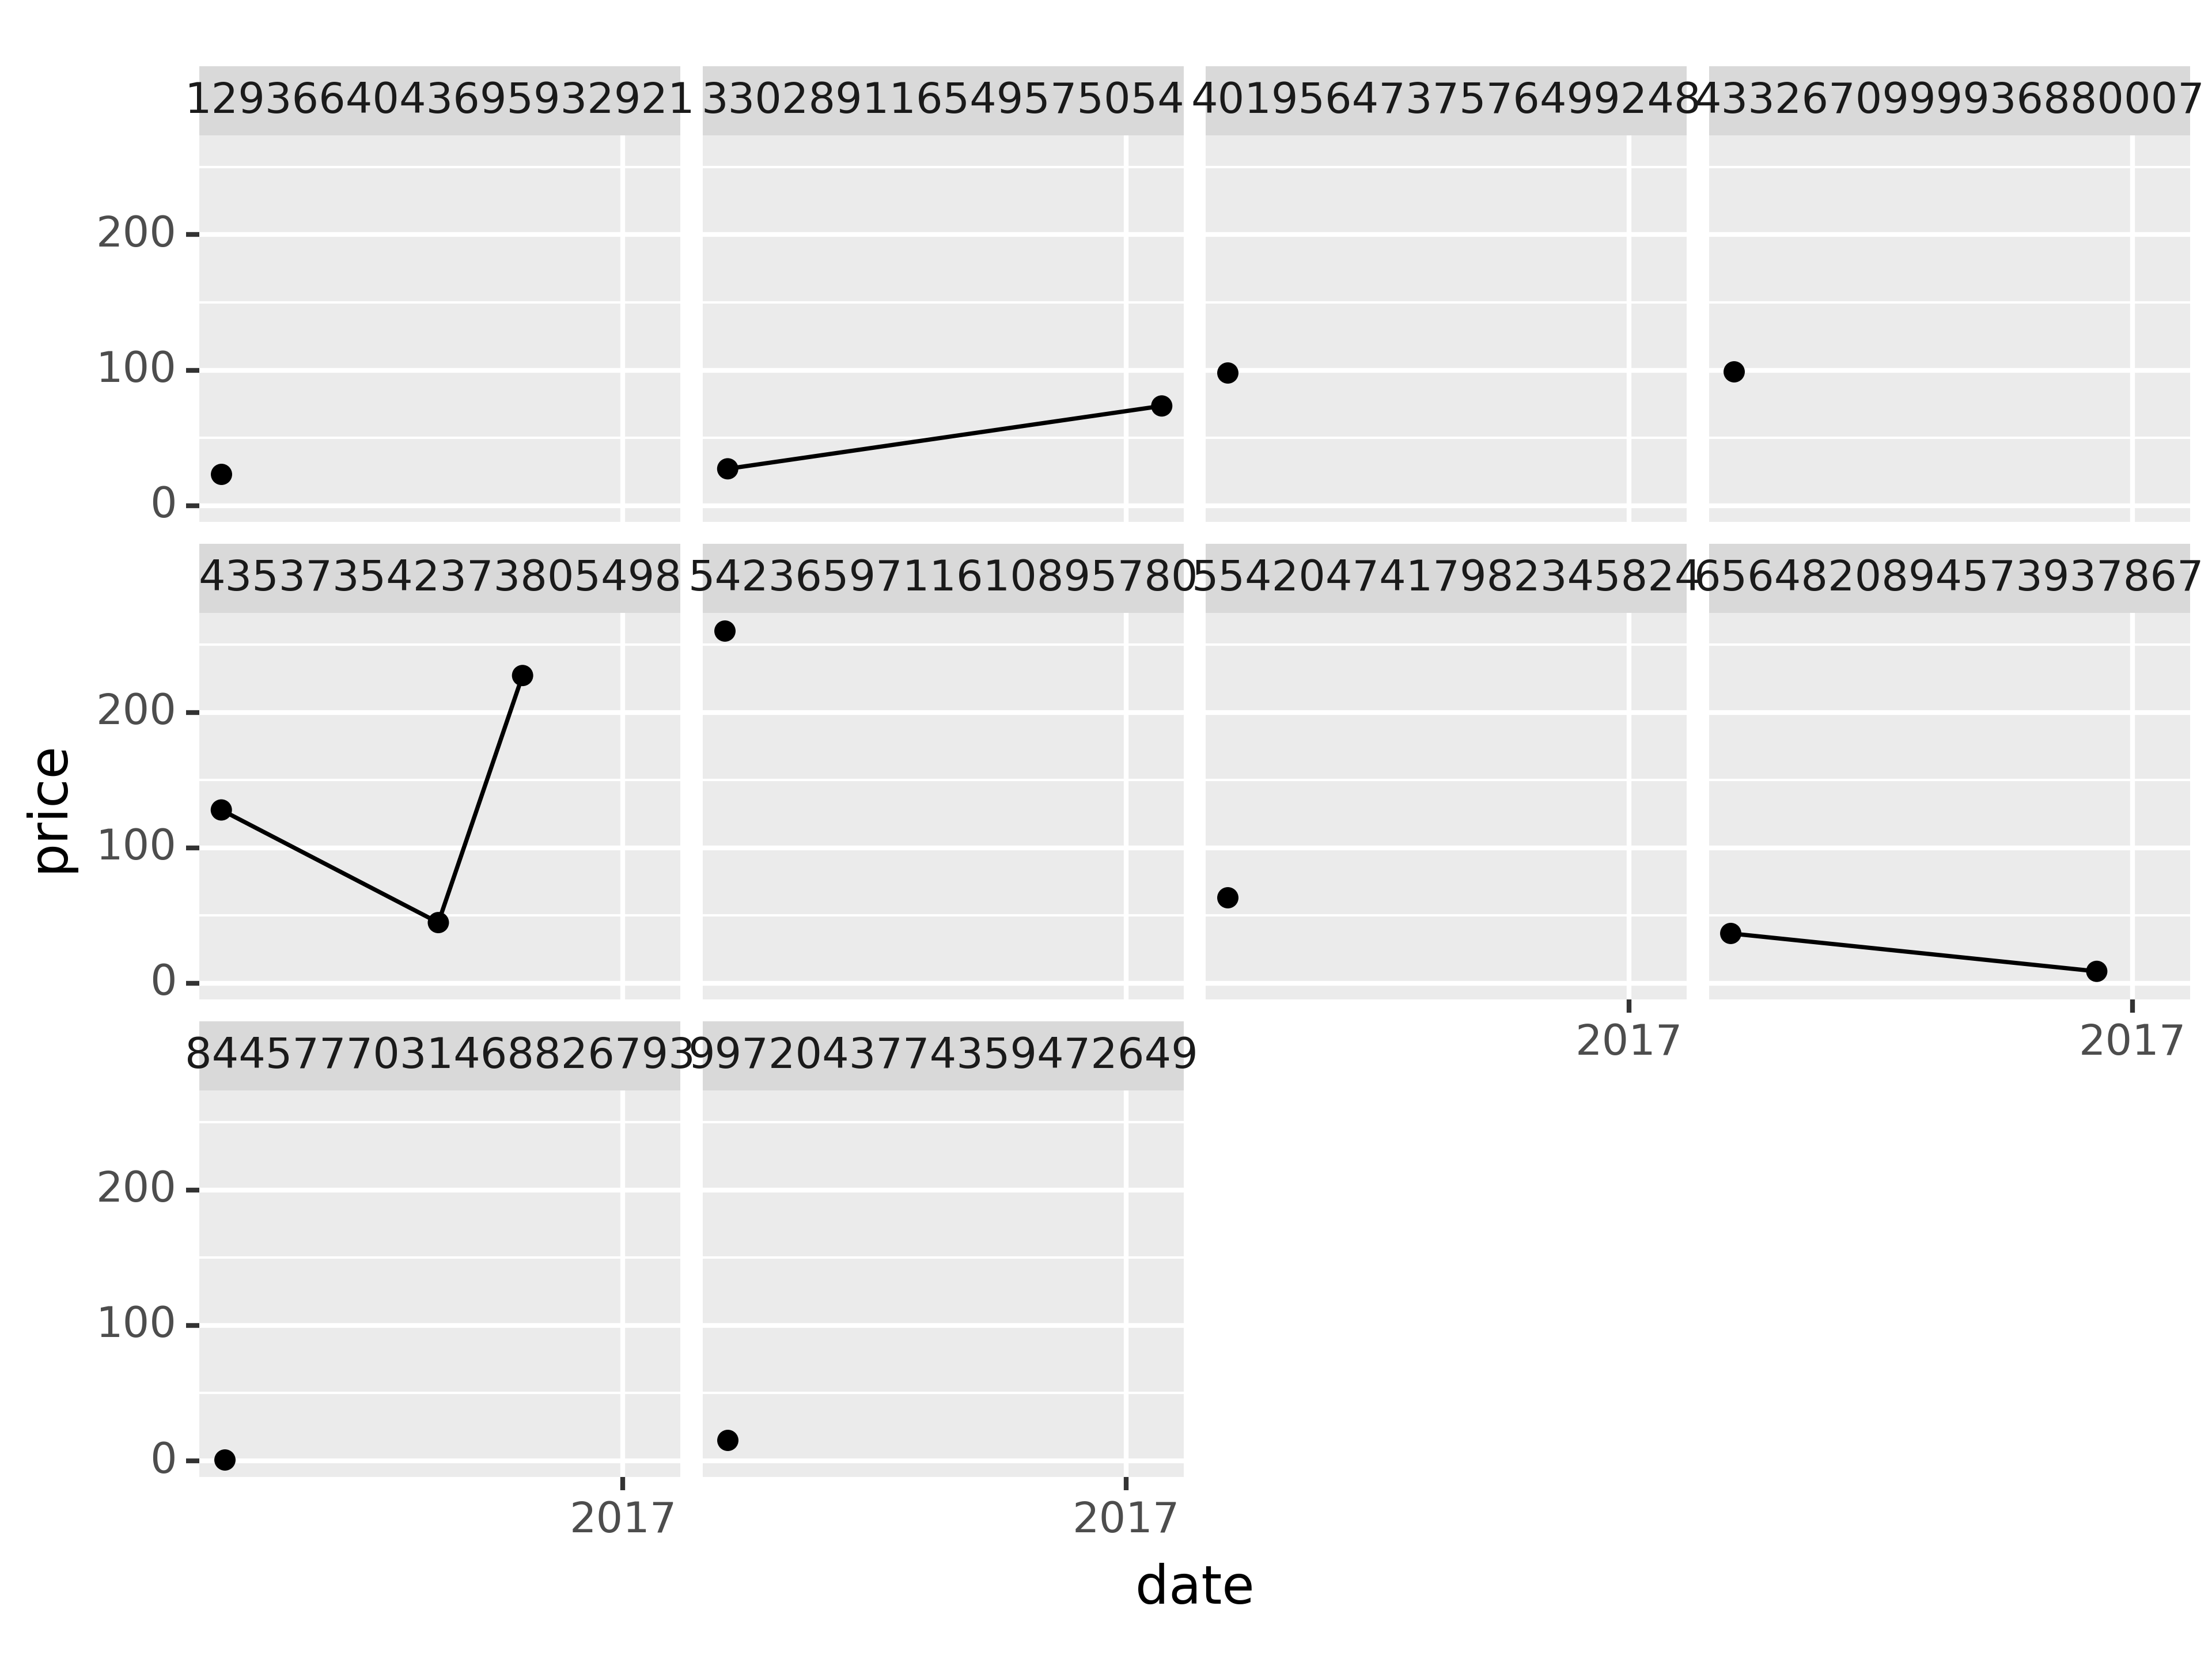

<Figure Size: (1920 x 1440)>

In [30]:
# plot randomly selected 10 customers using Plotnine
pn.ggplot(data=cust_id_subset_df, mapping=pn.aes('date', 'price', group='fullVisitorId')) \
    + pn.geom_line() \
    + pn.geom_point() \
    + pn.facet_wrap('fullVisitorId') \
    + pn.scale_x_date(date_breaks="1 year", date_labels="%Y")

This type of plot allows us to get a quick overview of customer purchasing pattern, which could provide a good indication of future business prospects. 

### 5.2 Temporal splitting 

In order to be able to predict purchases in the next 90-days, we need to draw a line, and split our data into two distinct time periods. 

In [31]:
# define cut-off period
n_days   = 90
max_date = google_merch_store['date'].max() 
max_date

Timestamp('2017-08-01 00:00:00')

In [32]:
cutoff = max_date - pd.to_timedelta(n_days, unit = "d")
cutoff

Timestamp('2017-05-03 00:00:00')

The cut-off date is 3 May 2017. The data for the period 1 August 2016 to 3 May 2017 will be used as training data by our machine learning model. Any data after this date will be used to verify the accuracy of predictions made on the prior data and is essentially therefore our held out test set. 

In [33]:
# Create our cohort dataset which covers the period up until the last 90 days
temporal_in_df = google_merch_store \
    [google_merch_store['date'] <= cutoff]
temporal_in_df

,fullVisitorId,date,quantity,product_name,price,product_revenue,total_transaction_revenue
0,3213840074316400693,2016-08-01,20,Color Changing Grip Pen,1.20,24.00,170.40
1,3213840074316400693,2016-08-01,20,Kick Ball,1.59,31.80,170.40
2,3213840074316400693,2016-08-01,20,Electronics Accessory Pouch,3.99,79.80,170.40
3,3213840074316400693,2016-08-01,20,Badge Holder,1.59,31.80,170.40
4,2976178532750719771,2016-08-01,4,Maze Pen,0.99,3.96,19.93
...,...,...,...,...,...,...,...
27320,2346359290191771618,2017-05-03,1,Google Tote Bag,9.99,9.99,173.44
27321,2346359290191771618,2017-05-03,10,Maze Pen,0.99,9.90,173.44
27322,2346359290191771618,2017-05-03,1,Badge Holder,1.99,1.99,173.44
27323,2346359290191771618,2017-05-03,10,Galaxy Screen Cleaning Cloth,1.99,19.90,173.44


In [34]:
# Create our 90-day dataset
temporal_out_df = google_merch_store \
    [google_merch_store['date'] > cutoff]
temporal_out_df

,fullVisitorId,date,quantity,product_name,price,product_revenue,total_transaction_revenue
27325,2618320847776659905,2017-05-04,1,Google Women's Vintage Hero Tee Black,10.63,10.63,17.63
27326,6720643639676411949,2017-05-04,1,Google Onesie Green,19.19,19.19,27.19
27327,7412836405745272778,2017-05-04,5,Google Collapsible Duffel Black,17.59,87.95,96.95
27328,372706149688864468,2017-05-04,4,BLM Sweatshirt,33.59,134.36,236.13
27329,372706149688864468,2017-05-04,3,BLM Sweatshirt,33.59,100.77,236.13
...,...,...,...,...,...,...,...
36741,8016003971239765913,2017-08-01,2,Android Men's Short Sleeve Hero Tee White,6.80,13.60,131.96
36742,8016003971239765913,2017-08-01,1,Women's Performance Full Zip Jacket Black,67.19,67.19,131.96
36743,8016003971239765913,2017-08-01,1,Android Men's Engineer Short Sleeve Tee Charcoal,15.99,15.99,131.96
36744,8016003971239765913,2017-08-01,1,Google Infant Short Sleeve Tee Red,13.59,13.59,131.96


### 5.3 RFM analysis

RFM analysis is a customer segmentation technique commonly used in marketing and analytics to categorize customers based on their behavior and interactions with a business. The acronym "RFM" stands for Recency, Frequency, and Monetary Value, which are three key dimensions used to evaluate and understand customer behavior. Here's a brief overview of each component:

#### Recency (R):

`Definition:` Recency refers to how recently a customer has interacted or made a purchase.\
`Calculation:` It is typically measured by the time elapsed since the customer's last purchase, activity, or interaction.\
`Objective:` Recent customers are often more engaged, so businesses may want to identify and target those who have interacted with the company recently.

#### Frequency (F):

`Definition:` Frequency measures how often a customer interacts or makes purchases.\
`Calculation:` It involves counting the number of transactions or interactions within a specific period.\
`Objective:` Higher frequency may indicate more loyal and engaged customers. Businesses may want to reward or incentivize customers with high frequency.

#### Monetary Value (M):

`Definition:` Monetary Value represents the total value of a customer's transactions.\
`Calculation:` It involves summing up the monetary value of all transactions made by a customer.\
`Objective:` Identifying customers with high monetary value helps businesses focus on their most valuable segments and tailor marketing strategies accordingly.

RFM analysis provides actionable insights into customer behavior, allowing businesses to develop targeted strategies for customer retention, acquisition, and overall business growth.

### 5.3.1 Create target variables from our 90-day data

In [36]:
# Make Targets from out data 
targets_df = temporal_out_df \
    .drop('quantity', axis=1) \
    .drop('product_name', axis=1) \
    .drop('product_revenue', axis=1) \
    .drop('total_transaction_revenue', axis=1) \
    .groupby('fullVisitorId') \
    .sum() \
    .rename({'price': 'spend_90_total'}, axis = 1) \
    .assign(spend_90_flag = 1)

targets_df

,spend_90_total,spend_90_flag
fullVisitorId,,
0003961110741104601,4.98,1
0006911334202687206,58.50,1
0010295111715775250,2.39,1
0012561433643490595,4.39,1
0014262055593378383,77.30,1
...,...,...
9973195165804180005,0.99,1
9973665079624172058,78.95,1
9974351919673138742,53.60,1


So we can see that out of a total of 9,995 customers, only 2,639 made a purchase in the final 90 day period.

### 5.3.2 Create recency (date) features 

In [37]:
max_date = temporal_in_df['date'].max()
max_date

Timestamp('2017-05-03 00:00:00')

In [38]:
recency_features_df = temporal_in_df \
    [['fullVisitorId', 'date']] \
    .groupby('fullVisitorId') \
    .apply(
        lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, "day")
    ) \
    .to_frame() \
    .set_axis(["recency"], axis=1)

recency_features_df

,recency
fullVisitorId,
0000213131142648941,-5.0
0002871498069867123,-253.0
0003450834640354121,-197.0
000435324061339869,-195.0
0007617910709180468,-142.0
...,...
9991633376050115277,-75.0
9994767073213036303,-267.0
9997409246962677759,-146.0


The above table shows, for each customer, how recent their most recent purchase was, with reference to the final purchase date of our recency dataset, 3 May 2017.

In [39]:
min_date = temporal_in_df['date'].min()
min_date

Timestamp('2016-08-01 00:00:00')

In [40]:
date_range = max_date - min_date
date_range

Timedelta('275 days 00:00:00')

### 5.3.3 Create frequency (count) features

In [41]:
frequency_features_df = temporal_in_df \
    [['fullVisitorId', 'date']] \
    .groupby('fullVisitorId') \
    .count() \
    .set_axis(['frequency'], axis=1)

frequency_features_df

,frequency
fullVisitorId,
0000213131142648941,1
0002871498069867123,1
0003450834640354121,5
000435324061339869,1
0007617910709180468,1
...,...
9991633376050115277,1
9994767073213036303,6
9997409246962677759,5


This shows how many purchase transactions each customer made.

### 5.3.4 Create monetary (price) features

In [42]:
# average spend per transaction
price_features_df = temporal_in_df \
    .groupby('fullVisitorId') \
    .aggregate(
        {
            'price': ["sum", "mean"]
        }
    ) \
    .set_axis(['price_sum', 'price_mean'], axis = 1)

price_features_df

,price_sum,price_mean
fullVisitorId,,
0000213131142648941,33.59,33.590000
0002871498069867123,5.99,5.990000
0003450834640354121,57.95,11.590000
000435324061339869,44.79,44.790000
0007617910709180468,18.99,18.990000
...,...,...
9991633376050115277,33.59,33.590000
9994767073213036303,51.94,8.656667
9997409246962677759,32.36,6.472000


This gives us the average spend per transaction for each customer.

### 5.3.5 Combine all features

In [43]:
features_df = pd.concat(
    [recency_features_df, frequency_features_df, price_features_df], axis = 1
) \
    .merge(
        targets_df, 
        left_index  = True, 
        right_index = True, 
        how         = "left"
    ) \
    .fillna(0) # where no spend populate with 0

features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
fullVisitorId,,,,,,
0000213131142648941,-5.0,1,33.59,33.590000,0.0,0.0
0002871498069867123,-253.0,1,5.99,5.990000,0.0,0.0
0003450834640354121,-197.0,5,57.95,11.590000,0.0,0.0
000435324061339869,-195.0,1,44.79,44.790000,0.0,0.0
0007617910709180468,-142.0,1,18.99,18.990000,0.0,0.0
...,...,...,...,...,...,...
9991633376050115277,-75.0,1,33.59,33.590000,0.0,0.0
9994767073213036303,-267.0,6,51.94,8.656667,0.0,0.0
9997409246962677759,-146.0,5,32.36,6.472000,0.0,0.0


## 6. Machine learning

Now that we have our recency, frequency and monetary features prepared, the next step is to leverage machine learning `regression models` to help us predict future customer spend based on these features.

In an ecommerce context, these regression models can provide valuable insights for:

- `Demand Forecasting:` Predicting future sales to optimize inventory levels and prevent stockouts or overstock situations.

- `Pricing Strategies:` Analyzing the impact of different pricing models and discounts on sales to determine the most effective pricing strategy.

- `Customer Segmentation:` Understanding customer segments based on purchasing behavior to tailor marketing messages and promotions.

- `Product Recommendations:` Enhancing personalized product recommendations based on individual customer preferences and historical data.

- `Marketing Optimization:` Allocating marketing budgets effectively by identifying the most influential factors driving sales.



### 6.1 XGBoost

[XGBoost (Extreme Gradient Boosting)](https://xgboost.readthedocs.io/en/stable/) is a powerful and efficient machine learning algorithm that belongs to the gradient boosting family. It has gained popularity for its high performance and effectiveness in various predictive modeling tasks.

In [44]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
X

,recency,frequency,price_sum,price_mean
fullVisitorId,,,,
0000213131142648941,-5.0,1,33.59,33.590000
0002871498069867123,-253.0,1,5.99,5.990000
0003450834640354121,-197.0,5,57.95,11.590000
000435324061339869,-195.0,1,44.79,44.790000
0007617910709180468,-142.0,1,18.99,18.990000
...,...,...,...,...
9991633376050115277,-75.0,1,33.59,33.590000
9994767073213036303,-267.0,6,51.94,8.656667
9997409246962677759,-146.0,5,32.36,6.472000


### 6.2 Regression model

#### 6.2.1 Build and train a model

In [45]:
# define our target variable
y_spend = features_df['spend_90_total']

# Regression model as we are trying to predict customer spend in next-90 days
xgb_reg_spec = XGBRegressor(
    objective="reg:squarederror",   
    random_state=123
)

xgb_reg_model = GridSearchCV(
    estimator=xgb_reg_spec, 
    param_grid=dict(
        learning_rate = [0.01, 0.1, 0.3, 0.5]
    ),
    scoring = 'neg_mean_absolute_error',
    refit   = True, # creates a 6th model which used for pred in production based on best of 5 models
    cv      = 5 # 5 fold cross-validation
)

In [46]:
# Train our model on the test day
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

### 6.2.2 Model evaluation

In [47]:
xgb_reg_model.best_score_

-2.2946875595942826

The interpretation is that are model is out by around $2 per transaction, which seems pretty reasonable.

In [48]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [49]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

### 6.2.3 Predicted customer spend ($) in next 90 days

In [50]:
predictions_reg = xgb_reg_model.predict(X)
predictions_reg

array([1.1863576 , 0.26471087, 0.26471087, ..., 0.26471087, 0.26471087,
       0.26471087], dtype=float32)

In [53]:
len(predictions_reg)

7478

### 6.3 Classification model

### 6.3.1 Probability of customer spend in the next 90 days

We will once again leverage XGBoost but this time a `classification` model is required as we are not trying to predict a $ value, but whether they will spend or not. There are a wide range of machine learning classification models, some of which are outlined below: 
    
- Logistic Regression
- Decision Trees
- Random Forest
- Support Vector Machines (SVM)
- K-Nearest Neighbors (KNN)
- Naive Bayes
- Neural Networks
- Ensemble Methods
- Association Rule Mining (e.g., Apriori Algorithm)

By leveraging these models, ecommerce businesses can enhance customer experiences, optimize marketing strategies, and improve overall operational efficiency.

### 6.3.2 Build and train a model

In [54]:
# # define our target variable
y_prob = features_df['spend_90_flag']

In [55]:
# Classification model as we are trying to predict whether customer spends in next-90 days or not
xgb_clf_spec = XGBClassifier(
    objective    = "binary:logistic",   
    random_state = 123
)

xgb_clf_model = GridSearchCV(
    estimator=xgb_clf_spec, 
    param_grid=dict(
        learning_rate = [0.01, 0.1, 0.3, 0.5]
    ),
    scoring = 'roc_auc',
    refit   = True,
    cv      = 5
)

In [56]:
# Train our model on the test data
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

### 6.3.3 Model evaluation

In [57]:
xgb_clf_model.best_score_

0.837403308391585

In [58]:
xgb_clf_model.best_params_

{'learning_rate': 0.1}

In [59]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

### 6.3.4 Predict probability of customer spend next-90 days

In [60]:
predictions_clf = xgb_clf_model.predict_proba(X) # predict prob rather than score
predictions_clf

array([[9.7599518e-01, 2.4004841e-02],
       [9.9948597e-01, 5.1402434e-04],
       [9.9950981e-01, 4.9017661e-04],
       ...,
       [9.9914837e-01, 8.5162191e-04],
       [9.9901974e-01, 9.8024833e-04],
       [9.9941909e-01, 5.8090949e-04]], dtype=float32)

The first value in the outputed array represents the probabilty of not making a purchase, with the second value representing the reciprocal, i.e. the probability of making a purchase. To illustrate, the first customer has a 2.4% probability of making a purchase in the next 90-days, the second customer, 5.1%, the third 4.9% and so on.

### 6.4 Feature importance

So which customer features can give us an insight into their future spending behaviour? If we can profile our customers we can better understand their unique preferences and enhance user experience which will ultimately translate into recurring future revenue streams.

### 6.4.1 Regression model

In [61]:
# dictionary of relative importance of features
imp_spend_amount_dict = xgb_reg_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain') 
imp_spend_amount_dict

{'recency': 21329.5546875,
 'frequency': 26971.447265625,
 'price_sum': 24244.16796875,
 'price_mean': 13376.1591796875}

In [62]:
# create a DataFrame from the dictionary
imp_spend_amount_df = pd.DataFrame(
    data  = {
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
) \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'] , x['value'])
    )
imp_spend_amount_df

,feature,value
0,recency,21329.554688
1,frequency,26971.447266
2,price_sum,24244.167969
3,price_mean,13376.159180


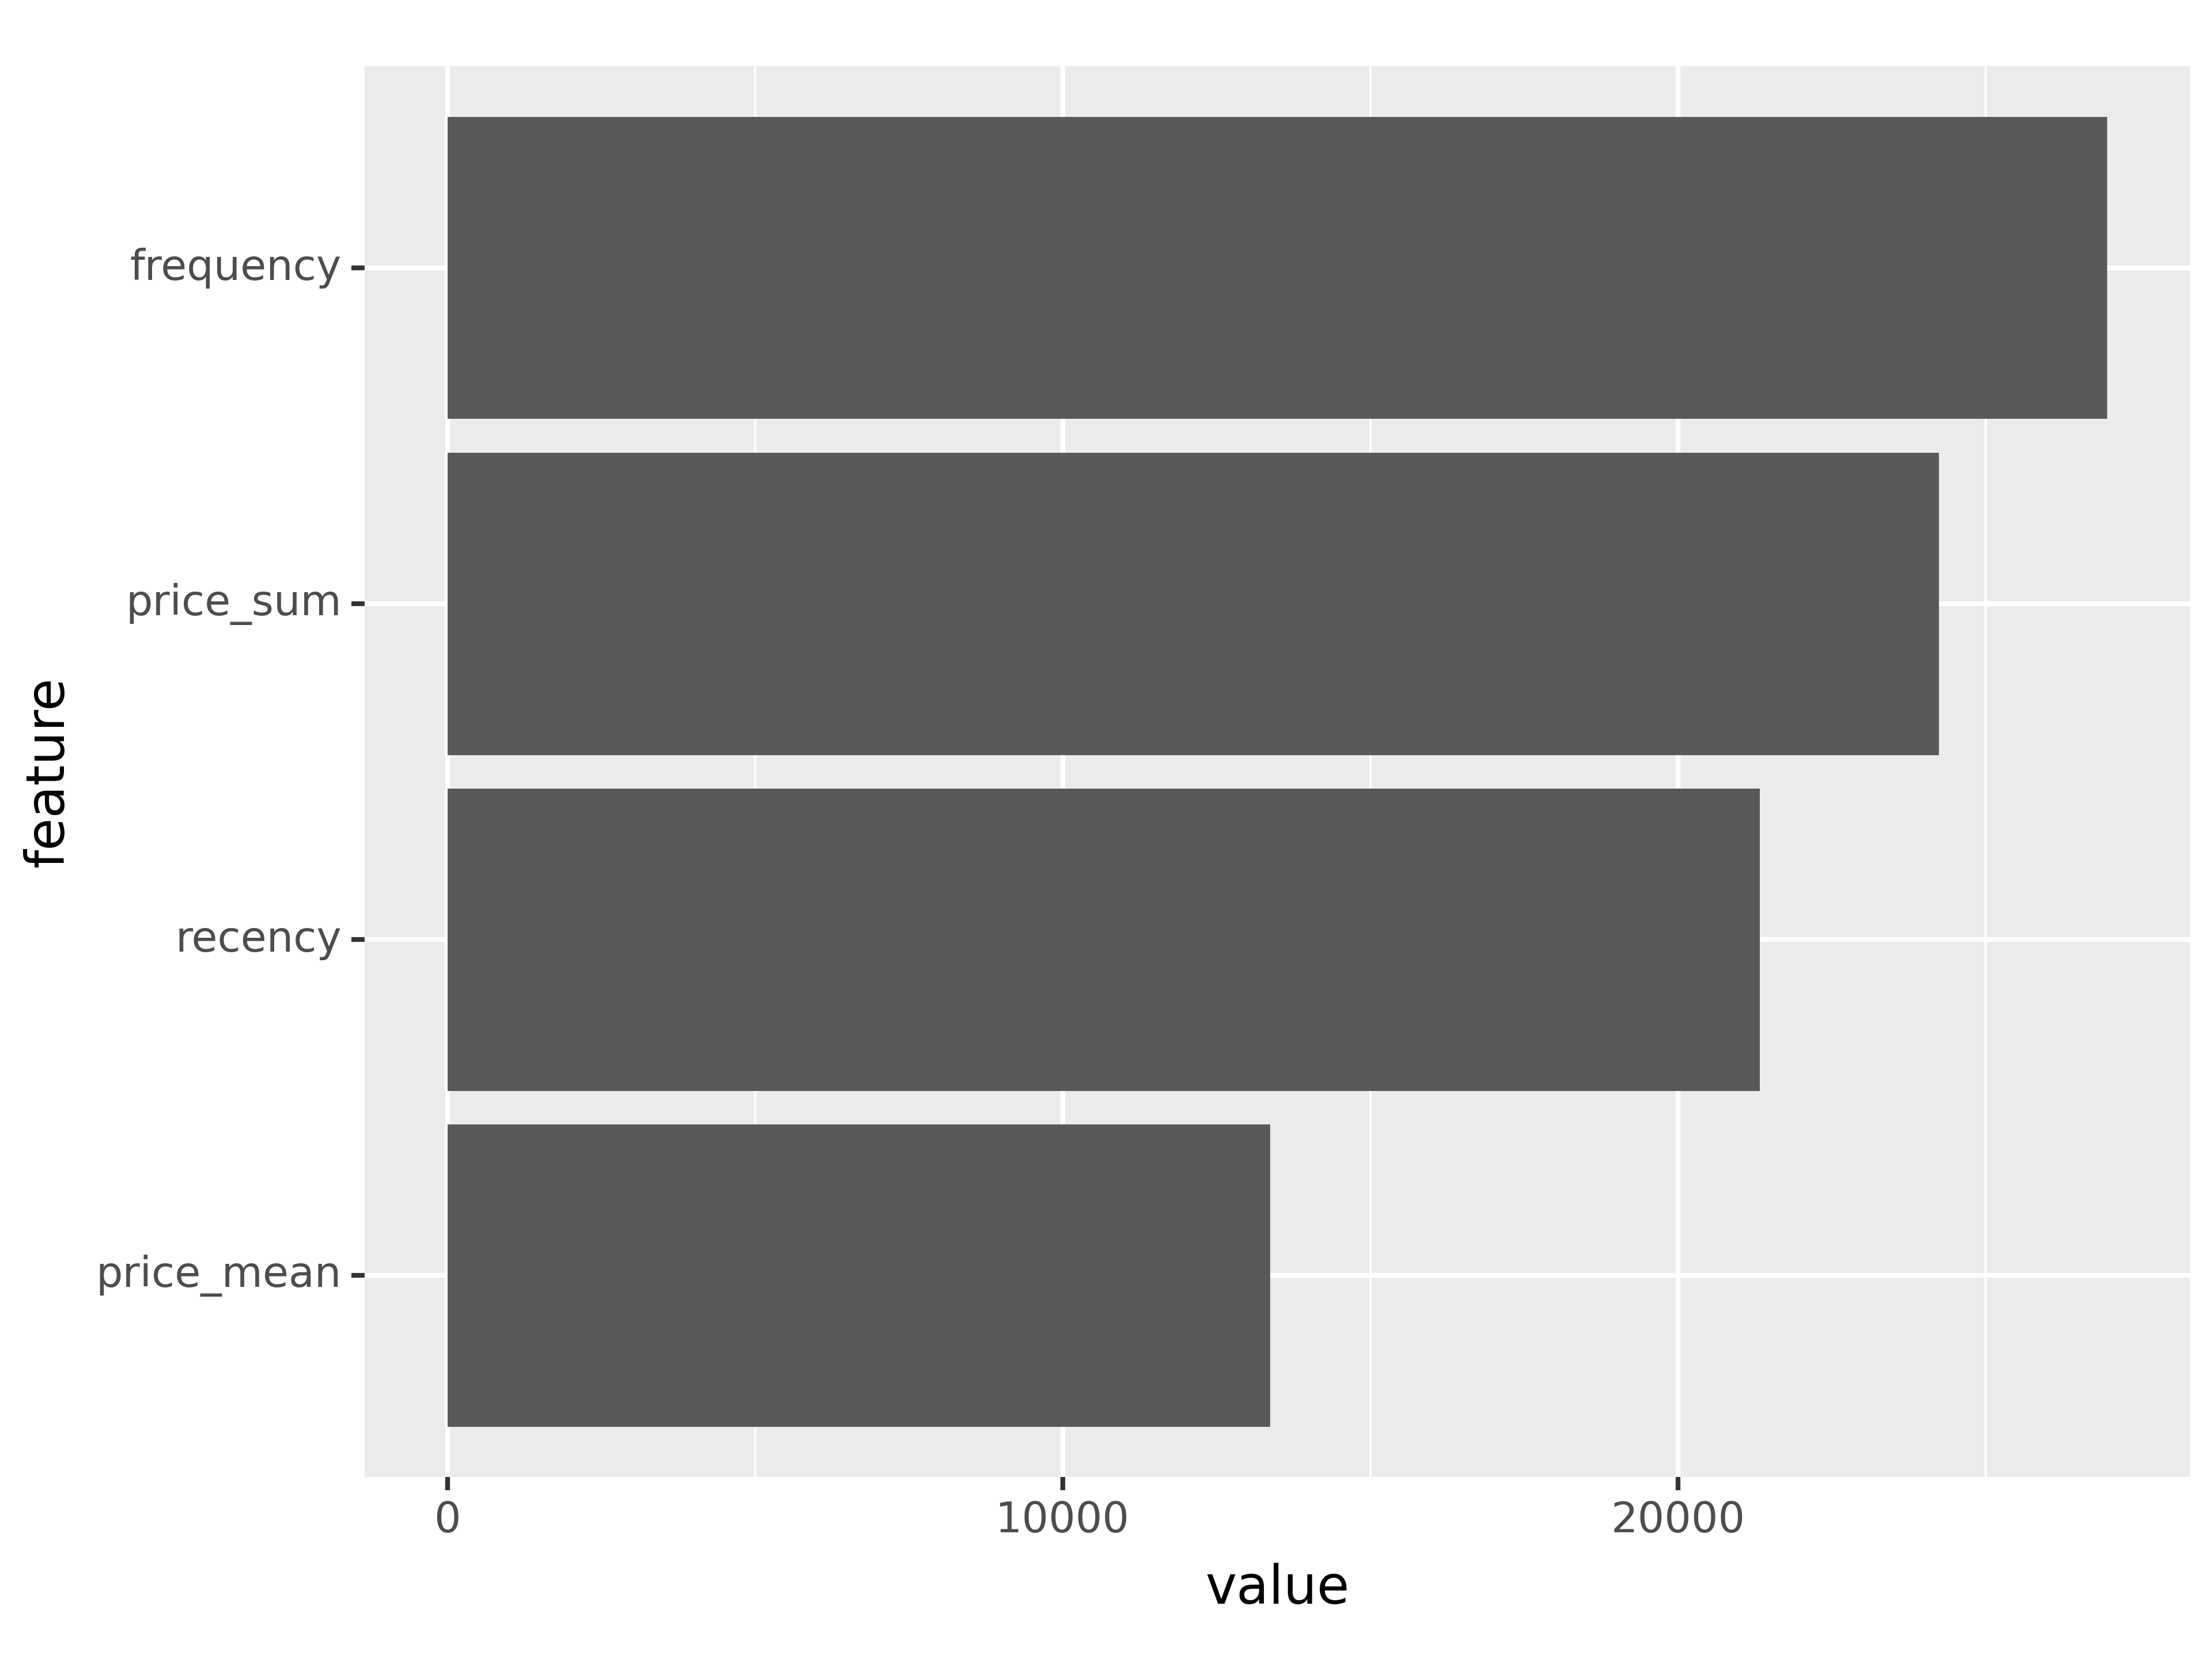

<Figure Size: (1920 x 1440)>

In [63]:
# Visualize feature importance
pn.ggplot(data=imp_spend_amount_df) + \
    pn.aes(x='feature', y='value') + \
    pn.geom_col() + \
    pn.coord_flip()

Intuitively, frequent spenders are generally likely to be a good indicator of future spend. This is corroborated in the above feature importance plot.

### 6.4.2 Classification model

In [64]:
# dictionary of relative importance of features
imp_spend_prob_dict = xgb_clf_model \
    .best_estimator_ \
    .get_booster() \
    .get_score(importance_type = 'gain') 
imp_spend_prob_dict

{'recency': 2.1909291744232178,
 'frequency': 1.2872744798660278,
 'price_sum': 1.2381023168563843,
 'price_mean': 1.1211071014404297}

In [65]:
# create a DataFrame from the dictionary
imp_spend_prob_df = pd.DataFrame(
    data  = {
        'feature':list(imp_spend_prob_dict.keys()),
        'value':list(imp_spend_prob_dict.values())
    }
) \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'] , x['value'])
    )
imp_spend_prob_df

,feature,value
0,recency,2.190929
1,frequency,1.287274
2,price_sum,1.238102
3,price_mean,1.121107


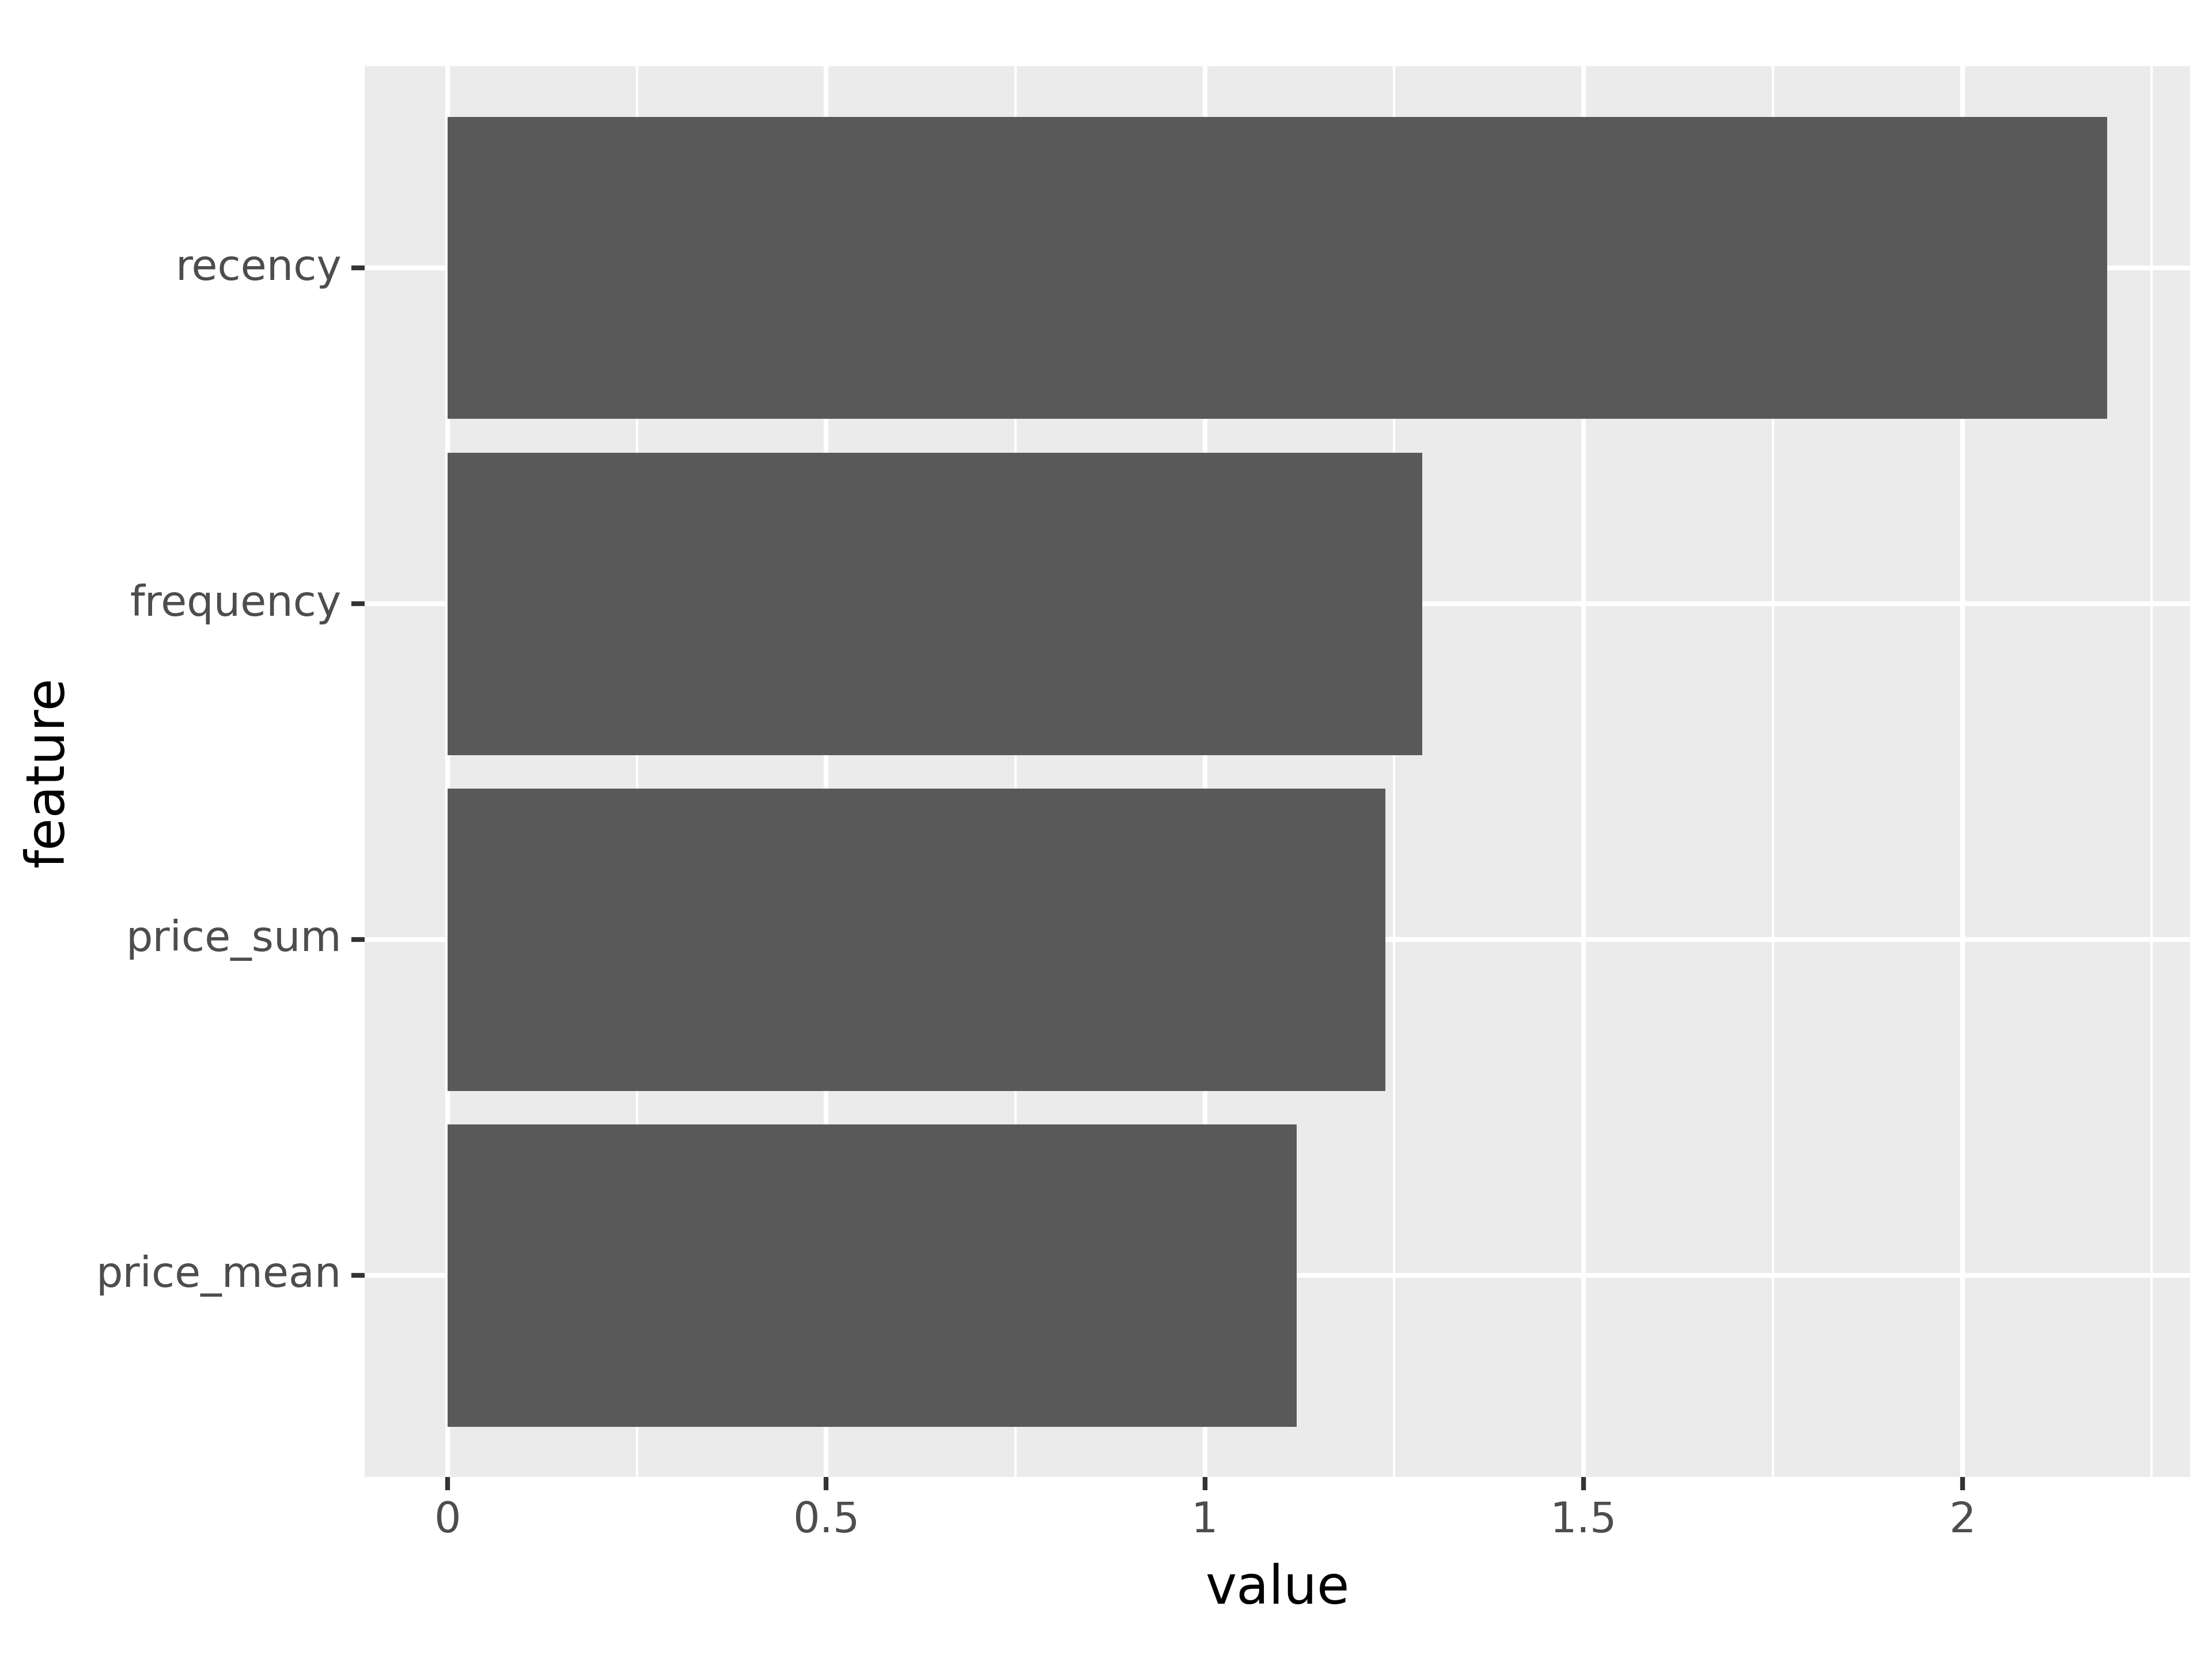

<Figure Size: (1920 x 1440)>

In [66]:
# Visualize feature importance
pn.ggplot(data = imp_spend_prob_df) + \
    pn.aes(x='feature', y='value') + \
    pn.geom_col() + \
    pn.coord_flip() 

In terms of the probability of future spend, if a customer has spent recently and frequently, then these are strong indicators. The amount spent and average spend are not considered to be important by the model.

## 7. Pickle (save) our predictions, features, and models

In [69]:
# Combine our predictions
predictions_df = pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
        features_df.reset_index()
    ], 
    axis=1
)
predictions_df

,pred_spend,pred_prob,fullVisitorId,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,1.186358,0.024005,0000213131142648941,-5.0,1,33.59,33.590000,0.0,0.0
1,0.264711,0.000514,0002871498069867123,-253.0,1,5.99,5.990000,0.0,0.0
2,0.264711,0.000490,0003450834640354121,-197.0,5,57.95,11.590000,0.0,0.0
3,0.264711,0.000253,000435324061339869,-195.0,1,44.79,44.790000,0.0,0.0
4,0.264711,0.000409,0007617910709180468,-142.0,1,18.99,18.990000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
7473,0.361555,0.012704,9991633376050115277,-75.0,1,33.59,33.590000,0.0,0.0
7474,0.264711,0.000526,9994767073213036303,-267.0,6,51.94,8.656667,0.0,0.0
7475,0.264711,0.000852,9997409246962677759,-146.0,5,32.36,6.472000,0.0,0.0
7476,0.264711,0.000980,9998597322098588317,-275.0,2,3.24,1.620000,0.0,0.0


In [70]:
import pickle

In [ ]:
with open("artifacts/predictions_df.pkl", "wb") as file:
    pickle.dump(predictions_df, file, protocol=4)

In [ ]:
# Pickle our predictions
predictions_df.to_pickle("artifacts/predictions_df.pkl")

In [ ]:
with open("artifacts/imp_spend_amount_df.pkl", "wb") as file:
    pickle.dump(imp_spend_amount_df, file, protocol=4)

In [ ]:
with open("artifacts/imp_spend_prob_df.pkl", "wb") as file:
    pickle.dump(imp_spend_prob_df, file, protocol=4)

In [ ]:
### Save our Feature Importances
imp_spend_amount_df.to_pickle("artifacts/imp_spend_amount_df.pkl")
imp_spend_prob_df.to_pickle("artifacts/imp_spend_prob_df.pkl")

In [ ]:
### Save Models
joblib.dump(xgb_reg_model, 'artifacts/xgb_reg_model.pkl')
joblib.dump(xgb_clf_model, 'artifacts/xgb_clf_model.pkl')

In [67]:
model = joblib.load('artifacts/xgb_reg_model.pkl')
model.predict(X)

array([1.1863576 , 0.26471087, 0.26471087, ..., 0.26471087, 0.26471087,
       0.26471087], dtype=float32)

## 8. Actionable outcomes

### Q1. Which customers have the highest spend `probability` in next 90-days? 

- Target for new products similar to what they have purchased in the past.

In [71]:
predictions_df \
    .sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,fullVisitorId,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
3747,103.428444,0.849751,4984366501121503466,-23.0,55,320.57,5.828545,258.50,1.0
6156,258.405396,0.836090,8197879643797712877,-7.0,65,2052.37,31.574923,657.03,1.0
1430,225.969971,0.827522,1957458976293878100,-14.0,109,2333.35,21.406881,338.26,1.0
3724,34.220909,0.806135,4950411203281265700,0.0,23,120.62,5.244348,92.35,1.0
5888,69.604485,0.782023,7813149961404844386,0.0,48,1906.50,39.718750,175.79,1.0
...,...,...,...,...,...,...,...,...,...
1307,0.264711,0.000214,1799218307967476916,-202.0,1,16.99,16.990000,0.00,0.0
2573,0.264711,0.000214,3461504855909388246,-206.0,1,16.99,16.990000,0.00,0.0
4435,0.264711,0.000214,5844997119511169482,-216.0,1,18.99,18.990000,0.00,0.0
6228,0.264711,0.000214,8292732469404938023,-227.0,1,16.99,16.990000,0.00,0.0


We can see that the model seems to be working well in terms of identifying those customers that are likely to spend in the next-90 days. The top 5 customers above ranked by probability of spend all actually spent. Conversely, the bottom 5 customers didn't spend.

### Q2. Which customers have recently purchased (within 90 days) but are unlikely to buy (probability less than 30%)? 

- Incentivize actions to increase probability.
- Provide discounts, encourage referring a friend, nurture by letting them know what's coming.

In [72]:
predictions_df \
    [
        predictions_df['recency'] > -90
    ] \
    [
        predictions_df['pred_prob'] < 0.30
    ] \
    .sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,fullVisitorId,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
2384,2.970100,0.299618,3197533100947860058,-33.0,7,153.44,21.920,86.54,1.0
419,4.334545,0.291470,0554420125524525961,-10.0,3,52.77,17.590,172.37,1.0
3406,2.242671,0.291250,4515197722749947898,-3.0,2,28.78,14.390,0.00,0.0
1861,2.242671,0.291250,2518379317255532090,-3.0,2,28.78,14.390,28.78,1.0
5688,3.153815,0.290945,7548511681521037018,-2.0,4,33.98,8.495,42.97,1.0
...,...,...,...,...,...,...,...,...,...
6446,0.594005,0.001943,8590369633898567459,-35.0,1,2.39,2.390,0.00,0.0
5561,0.594005,0.001943,7390358029425621068,-35.0,1,1.99,1.990,0.00,0.0
2165,0.361555,0.001671,293387037477216156,-72.0,1,1.99,1.990,0.00,0.0
2666,0.361555,0.001671,3573113591289892546,-74.0,1,1.99,1.990,0.00,0.0


### Q3. Missed opportunities: Big spenders that could be unlocked 

- Send bundle offers encouraging volume purchases
- Focus on missed opportunities

In [73]:
# identify those customers predicted to spend but did not
predictions_df \
    [
        predictions_df['spend_90_total'] == 0.0
    ] \
    .sort_values('pred_spend', ascending=False) 

,pred_spend,pred_prob,fullVisitorId,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
2955,81.598740,0.126212,3955127543379144640,-2.0,8,358.32,44.790000,0.0,0.0
2565,33.736187,0.063039,3449924104971285851,-91.0,14,483.86,34.561429,0.0,0.0
5696,33.736187,0.085885,7561014297963838461,-58.0,18,522.82,29.045556,0.0,0.0
2927,30.029305,0.017011,3916992730920009646,-64.0,7,416.73,59.532857,0.0,0.0
4026,30.029305,0.009925,5349155616428631188,-76.0,13,391.87,30.143846,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1767,-0.646184,0.025690,2396848817613598114,-59.0,44,1416.56,32.194545,0.0,0.0
5808,-0.646184,0.023305,7713012430069756739,-62.0,18,783.82,43.545556,0.0,0.0
751,-0.646184,0.017749,1045033759778661078,-86.0,22,657.38,29.880909,0.0,0.0
7001,-0.646184,0.013225,9349161317881541522,-50.0,29,896.71,30.921034,0.0,0.0


## Communication of findings

### 9.1 e-commerce analytics dashboard using Dash for viewing locally

We can create an interactive analytics dashboard which can be shared with the Marketing Department to enable targeted campaigns to be launched, by following these 3 steps:

1. Create a virtual environment from the command line :

        conda env create -f environment.yml
    
This minimizes the risk of conflicting package dependencies or dependency hell! If you do end up down there then you can refer to [the documentation](https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts). Good luck!

2. Activate the environment:

        conda activate google_merch_clv (this is the name specified in the yaml file below - can change this as desired)
        

3. Launch the app:

        python app.py    
        
The dashboard can then be viewed by visiting http://127.0.0.1:8050/ in your web browser.

### 9.2 Deployment of Dash e-commerce app

Now that we have tested our app and it runs successfully locally, it's time to deploy it! There are a variety of platforms around, most have some kind of pay wall. [Python Anywhere](https://www.pythonanywhere.com/) offer a basic free hosting service but tou might find you need a bit more resource. At the time of writing $7/$8 per month allows you to have two apps hosted and gives you 2000s of CPU usage and 2.0GB of file storage.

It has a very user-friendly interface and after reviewing some online video tutorials and debugging using the support forums and stackoverflow, i was able to get [my app](http://stephen137.pythonanywhere.com/) running.

## 10. Key takeaways

This project demonstrated my proficiency in:

- `business analytics`: the project was framed by two business problems/questions which are relevant to ecommerce businesses
- `SQL:` transform a complex real-life BigData datset with nested fields, into meaningful insights with regard to customer behaviour
- `pandas`: data cleansing and wrangling
- `machine learning:` created a BASELINE regression and classification model and performed feature engineering to enhance model performance
- `visualization`: using the plotly and plotnine libraries
- `app creation` : deployment of an interactive Dash app

At the time of writing I am currently working on a custoomer segmentation and recommendation engine project which makes use of the same dataset.